# EECE 550 HW 2 Question 7: Boost Converter
Shelby Quiring, 10157162, March 15th 2024

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import sympy as sp
import control as ctr
import control.matlab as ctrm

In [2]:
# Inputs
Vi = 14  # V
Vo = 52  # V
Io = 10  # A
delta_Vo_percent = 0.02  # %pp
delta_Il_percent = 0.04  # %pp
Fsw = 95e3  # Hz, switching frequency

# Derived quantities
R = Vo / Io
Ii = (Vo/Vi) * Io
D = (Vo-Vi)/Vo

IL = Ii
Vc = Vo

# Component values
delta_il_pp = delta_Il_percent * Io / (1-D)
delta_vo_pp = delta_Vo_percent * Vo
C = Vo * D / (Fsw * R * delta_vo_pp)
L = Vi * D / (Fsw * delta_il_pp)

print(f'Duty Cycle D: {D*100:.1f} %')
print(f'Capacitor: {C * 1e6:.3f} uF')
print(f'Inductor: {L * 1e6:.3f} uH\n')
print(f'Load Resistor: {R:.3f} Ohms\n')

# Define matricies
gamma = np.diag([L, C])

alpha = np.array([
    [ 0,     -(1-D) ],
    [ 1-D,   -1/R   ]
])

# Only duty cycle input
beta = np.array([
    [ Vc ],
    [-IL ]
])

A = np.linalg.inv(gamma) @ alpha
B = np.linalg.inv(gamma) @ beta
C_ = np.array([0, 1])
D_ = np.array([0])

print(f'A: \n{A}\n')
print(f'B: \n{B}\n')

# Check controllability
ctr_rank = np.linalg.matrix_rank(ctr.ctrb(A, B))
print(f'Controllability Rank: {ctr_rank}\n')

# Make state space model
sys = ctr.ss(A, B, C_, D_)
print('Linearized Model:')
display(sys)

# Check stability
e, V = sci.linalg.eig(A)
print('\nEigvals of A Matrix:')
print(e)

Duty Cycle D: 73.1 %
Capacitor: 73.964 uF
Inductor: 72.485 uH

Load Resistor: 5.200 Ohms

A: 
[[    0.         -3714.28571429]
 [ 3640.         -2600.        ]]

B: 
[[ 717387.75510204]
 [-502171.42857143]]

Controllability Rank: 2

Linearized Model:


<LinearIOSystem:sys[2]:['u[0]']->['y[0]']>


Eigvals of A Matrix:
[-1300.+3439.47670438j -1300.-3439.47670438j]


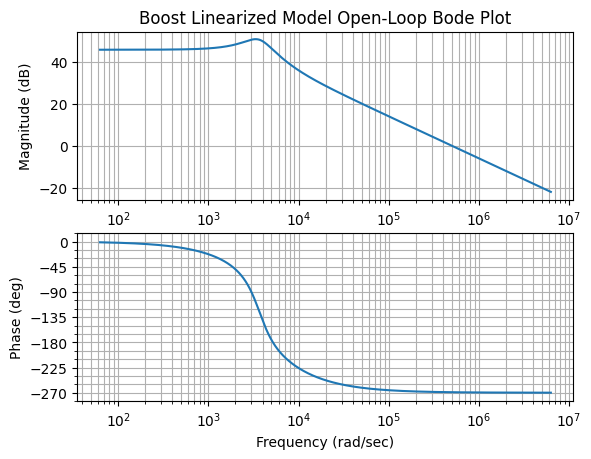

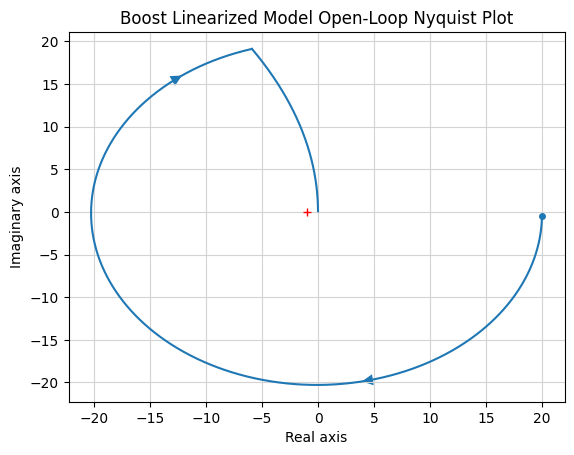

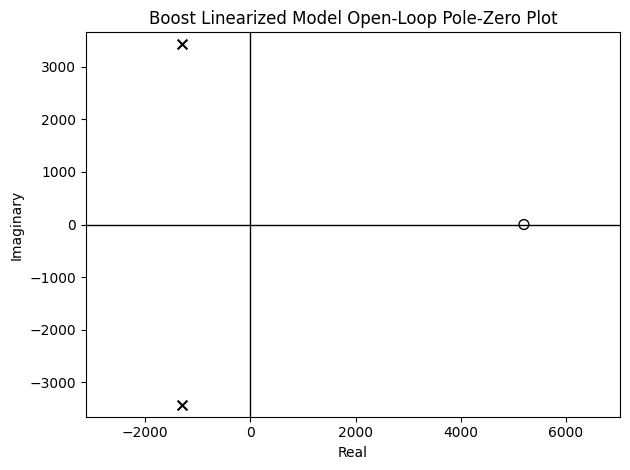

In [3]:
# Look at the frequency response and other control plots
fvec = np.logspace(1, 6, 10000)
omegavec = fvec * 2 * np.pi

fig = plt.figure()
ctr.bode_plot(sys, omegavec)
fig.axes[0].set_title('Boost Linearized Model Open-Loop Bode Plot')

fig, ax = plt.subplots()
ctr.nyquist(sys, omegavec, primary_style=['-', '-'], mirror_style=False)
ax.set_title('Boost Linearized Model Open-Loop Nyquist Plot')

fig = plt.figure() 
ctr.pzmap(sys)
plt.title('Boost Linearized Model Open-Loop Pole-Zero Plot')
fig.tight_layout()

Control-To-Output Transfer Function Equation:


-Ro*(I_L*L_1*S + V_C*(Do - 1))/(C_1*L_1*Ro*S**2 + L_1*S + Ro*(Do - 1)**2)

Evaluated:


(72.8 - 0.014*S)/(2.78789258079199e-8*S**2 + 7.24852071005917e-5*S + 0.376923076923077)

Coefficient Arrays:

Num: [-0.014000000000000002, 72.8]
Den: [2.787892580791989e-08, 7.248520710059172e-05, 0.3769230769230771]

Transfer Function:



TransferFunction(array([-1.40e-02,  7.28e+01]), array([2.78789258e-08, 7.24852071e-05, 3.76923077e-01]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


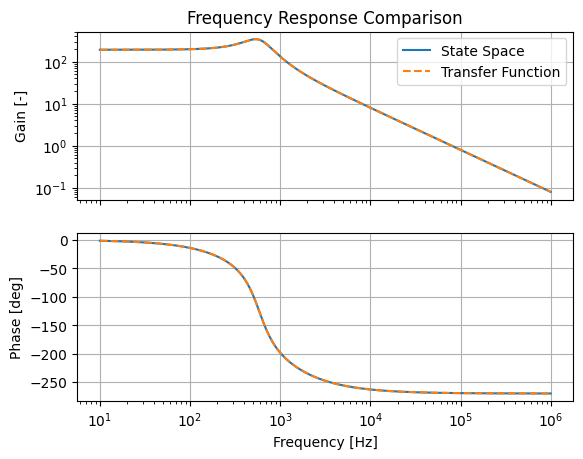

In [4]:
# Get the transfer function and compare to the state space model
# Define symbols for symbolic calculation
L_1, C_1, I_L, V_C, Ro, Do, S = sp.symbols('L_1 C_1 I_L V_C Ro Do S')

# Define intermediate transfer functions
G1 = C_1*S + (1-Do)**2/(L_1*S) + 1/Ro
G2 = V_C*(1-Do)/(L_1*S) - I_L

# Define control to output transfer function
G_tot = sp.simplify(G2 / G1)
print('Control-To-Output Transfer Function Equation:')
display(G_tot)

# Evaluate the expression
substitution = [ # Replace symbolic varibles with real ones
    (L_1, L),
    (C_1, C),
    (I_L, IL),
    (V_C, Vc),
    (Ro, R), 
    (Do, D)
]

G_tot_result = G_tot.subs(substitution).evalf().simplify()
print('Evaluated:')
display(G_tot_result)

# Create a transfer function object
num = [float(x) for x in G_tot_result.as_numer_denom()[0].as_poly().all_coeffs()]
den = [float(x) for x in G_tot_result.as_numer_denom()[1].as_poly().all_coeffs()]
H = ctr.tf(num, den)

print('Coefficient Arrays:\n')
print(f'Num: {num}')
print(f'Den: {den}')

print('\nTransfer Function:\n')
display(H)


# Plot the bode plot using this transfer function and compare to the state space model
fig, ax = plt.subplots(2, 1, sharex=True)
mss, pss, _ = ctrm.freqresp(sys, omegavec)
mtf, ptf, _ = ctrm.freqresp(H, omegavec)
ax[0].loglog(fvec, mss, label='State Space')
ax[0].loglog(fvec, mtf, '--', label='Transfer Function')
ax[0].grid('enable')
ax[0].legend()
ax[0].set_title('Frequency Response Comparison')
ax[0].set_ylabel('Gain [-]')

ax[1].semilogx(fvec, np.unwrap(pss) * 180 / np.pi, label='State Space')
ax[1].semilogx(fvec, np.unwrap(ptf) * 180 / np.pi, '--', label='Transfer Function')
ax[1].grid('enable')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Phase [deg]')

# Save the figure
plt.savefig(f'figs/boost_freqresp.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


4 states have been removed from the model


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


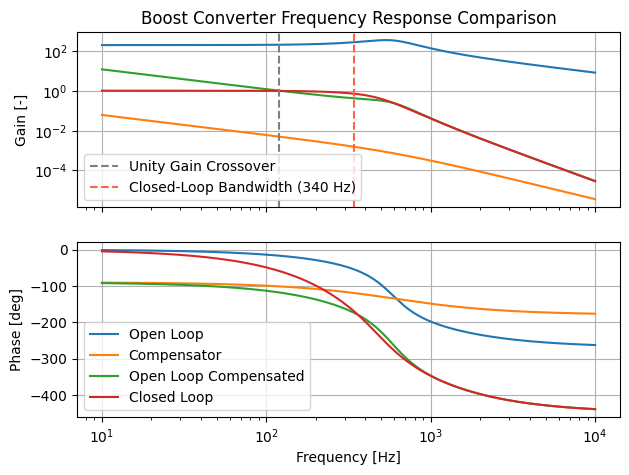

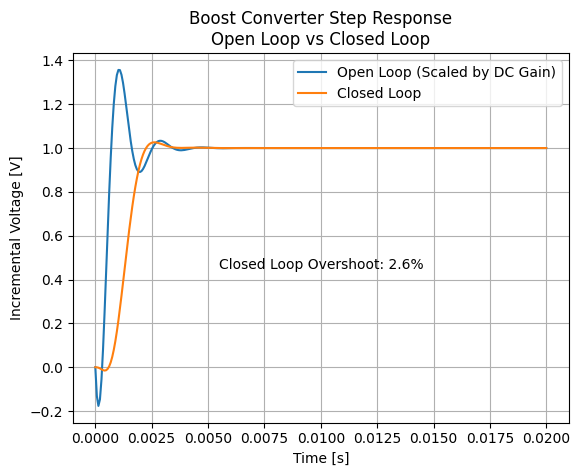

In [5]:
### Compensator design
# Set up s variable
s = ctr.tf([1, 0], 1)

# Define desired unity gain crossover
wc = 2*np.pi*120  # rad/s 

# Calulate integrator gain and lowpass filter cutoff
wf = wc * 5

# Define sub-controllers
integral = 1 / s
lowpass_filter = (wf / (s + wf))

# Define preliminary compensator and preliminary new loop return ratio
CT_1 = integral * lowpass_filter
LR_1 = CT_1 * H  # Compen/sated loop return ratio

# Calculate proportional gain required to achieve the desired crossover
Kp = 1 / ctr.freqresp(LR_1, wc)[0][0] 

# Finally, define full controller and full compensated loop return
CT = Kp * CT_1
LR = CT * H # Fully compensated loop return ratio

# Define the closed loop system
Gcl = LR / (1 + LR)


# Plot the frequency response
fvec = np.logspace(1, 4, 10000)
omegavec = fvec * 2 * np.pi


fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 5))
mol, pol, _ = ctrm.freqresp(H, omegavec)
mc, pc, _ = ctrm.freqresp(CT, omegavec)
molc, polc, _ = ctrm.freqresp(LR, omegavec)
mcl, pcl, _ = ctrm.freqresp(Gcl, omegavec)

bdw = ctr.bandwidth(ctr.minreal(Gcl))

ax[0].loglog(fvec, mol)#, label='Open Loop')
ax[0].loglog(fvec, mc)#, label='Compensator')
ax[0].loglog(fvec, molc)#, label='Open Loop Compensated')
ax[0].loglog(fvec, mcl)#, label='Closed Loop')
ax[0].axvline(wc / (2*np.pi), color='0.5', linestyle='--', label='Unity Gain Crossover')
ax[0].axvline(bdw / (2*np.pi), color='tomato', linestyle='--', label=f'Closed-Loop Bandwidth ({bdw/ (2*np.pi):.0f} Hz)')
ax[0].grid('enable')
ax[0].legend()
ax[0].set_title('Boost Converter Frequency Response Comparison')
ax[0].set_ylabel('Gain [-]')
ax[1].semilogx(fvec, np.unwrap(pol) * 180 / np.pi, label='Open Loop')
ax[1].semilogx(fvec, np.unwrap(pc) * 180 / np.pi, label='Compensator')
ax[1].semilogx(fvec, np.unwrap(polc) * 180 / np.pi, label='Open Loop Compensated')
ax[1].semilogx(fvec, np.unwrap(pcl) * 180 / np.pi, label='Closed Loop')
ax[1].grid('enable')
ax[1].legend()
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Phase [deg]')

# Save the figure
plt.savefig(f'figs/boost_controller.eps', format='eps')

# Plot the step response
fig, ax = plt.subplots()
yol, tol = ctrm.step(H, 0.02)
ycl, tcl = ctrm.step(Gcl, 0.02)
# ycla, tcla = ctrm.step(Gcla, 0.05)
ax.plot(tol, yol / ctrm.dcgain(H), label='Open Loop (Scaled by DC Gain)')
ax.plot(tcl, ycl, label='Closed Loop ')
# ax.plot(tcla, ycla, label='Closed Loop Alt')
ax.text(0.0055, 0.45, f'Closed Loop Overshoot: {100*(np.max(ycl) - 1):.1f}%')
ax.grid('enable')
ax.legend()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Incremental Voltage [V]')
ax.set_title('Boost Converter Step Response\nOpen Loop vs Closed Loop')

# Save the figure
plt.savefig(f'figs/boost_steptest.eps', format='eps')

Controller State Space Model:


StateSpace(array([[-3.76991118e+03, -0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00]]), array([[1.],
       [0.]]), array([[    0.        , 14390.46273858]]), array([[0.]]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


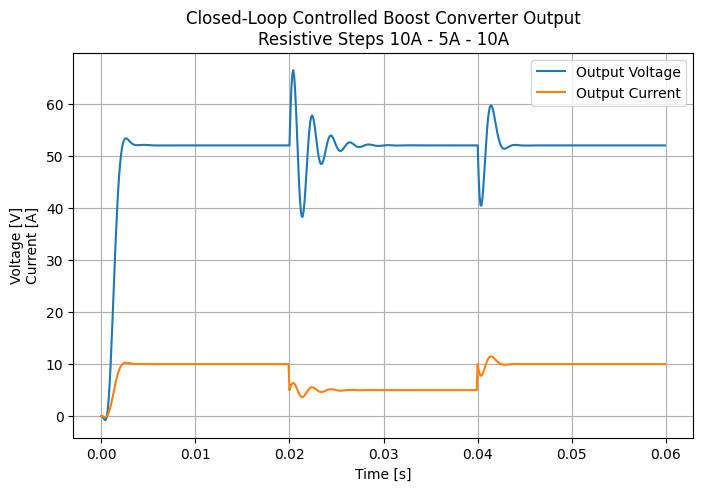

In [6]:
# Resistive step responses

# Define new systems for the closed-loop simulations
gamma = np.diag([L, C])

alpha_10 = np.array([
    [ 0,     -(1-D)    ],
    [ 1-D,   -1/(R)    ]
])

alpha_5 = np.array([
    [ 0,     -(1-D)    ],
    [ 1-D,   -1/(2*R)  ]
])

# Only duty cycle input
beta = np.array([
    [ Vc ],
    [-IL ]
])

A_10 = np.linalg.inv(gamma) @ alpha_10
A_5 = np.linalg.inv(gamma) @ alpha_5
B_ = np.linalg.inv(gamma) @ beta
C_ = np.array([0, 1])
D_ = np.array([0])

# Get state space model for controller
CT_ss = ctr.tf2ss(CT)
print('Controller State Space Model:')
display(CT_ss)


Ac = CT_ss.A
Bc = CT_ss.B
Cc = CT_ss.C
Dc = CT_ss.D

row_ol, col_ol = np.shape(A_10)
row_c, col_c = np.shape(Ac)

# Construct augmented controlled matricies
Baug = np.block([
    [ B_ @ Dc ],
    [   Bc    ]
])

Caug = np.block([ C_, np.zeros((1, col_c)) ])

Daug = 0

Aaug_10 = np.block([
    [         A_10,              B_ @ Cc  ],
    [np.zeros((row_c, col_ol)),     Ac    ]
]) - Baug @ Caug

Aaug_5 = np.block([
    [         A_5,               B_ @ Cc  ],
    [np.zeros((row_c, col_ol)),     Ac    ]
]) - Baug @ Caug


# Make state space model
sys_aug_10 = ctr.ss(Aaug_10, Baug, Caug, Daug)
sys_aug_5 = ctr.ss(Aaug_5, Baug, Caug, Daug)

sys_ol_10 = ctr.ss(A_10, B_, C_, D_)
sys_ol_5 = ctr.ss(A_5, B_, C_, D_)


# Define input vectors
dt = 1e-4
Tmax = 0.02
time_segment = np.arange(0, Tmax, dt)
u_segment = np.ones_like(time_segment) * Vo
u_segment_ol = np.ones_like(time_segment) * Vo / ctr.dcgain(sys_ol_10)
y0 = 0

# Simulate nominal operation
yout_1, tout_1, xout_1 = ctrm.lsim(sys_aug_10, u_segment, time_segment) 
yout_ol_1, tout_ol_1, xout_ol_1 = ctrm.lsim(sys_ol_10, u_segment_ol, time_segment) 

# Simulate current step down
yout_2, tout_2, xout_2 = ctrm.lsim(sys_aug_5, u_segment, time_segment, xout_1[-1])
yout_ol_2, tout_ol_2, xout_ol_2 = ctrm.lsim(sys_ol_5, u_segment_ol, time_segment, xout_ol_1[-1]) 

# Simulate current step up
yout_3, tout_3, xout_3 = ctrm.lsim(sys_aug_10, u_segment, time_segment, xout_2[-1]) 
yout_ol_3, tout_ol_3, xout_ol_3 = ctrm.lsim(sys_ol_10, u_segment_ol, time_segment, xout_ol_2[-1]) 

# Plot all the results
time_all = np.array([*time_segment, *(time_segment + Tmax), *(time_segment + Tmax*2)])

yout_all = np.array([*yout_1, *yout_2, *yout_3])
xout_all = np.block([xout_1.T, xout_2.T, xout_3.T])
current_all = np.array([*yout_1 * (-alpha_10[-1, -1]), *yout_2 * (-alpha_5[-1, -1]), *yout_3 * (-alpha_10[-1, -1])])

yout_ol_all = np.array([*yout_ol_1, *yout_ol_2, *yout_ol_3])
xout_ol_all = np.block([xout_ol_1.T, xout_ol_2.T, xout_ol_3.T])
current_ol_all = np.array([*yout_ol_1 * (-alpha_10[-1, -1]), *yout_ol_2 * (-alpha_5[-1, -1]), *yout_ol_3 * (-alpha_10[-1, -1])])


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(time_all, yout_all, label='Output Voltage')
ax.plot(time_all, current_all, label='Output Current')
ax.grid('enable')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Voltage [V]\nCurrent [A]')
ax.set_title('Closed-Loop Controlled Boost Converter Output\nResistive Steps 10A - 5A - 10A')
ax.legend()

# Save the figure
plt.savefig(f'figs/boost_steps.eps', format='eps')